<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/auto_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Latent Workflows
Pipeline Components and Business Requirements as Latent Feature Stores
dehls - pinballsurgeon@gmail.com /

POC - Given +20k Chess Games, predict most common Openings per sequences of moves.

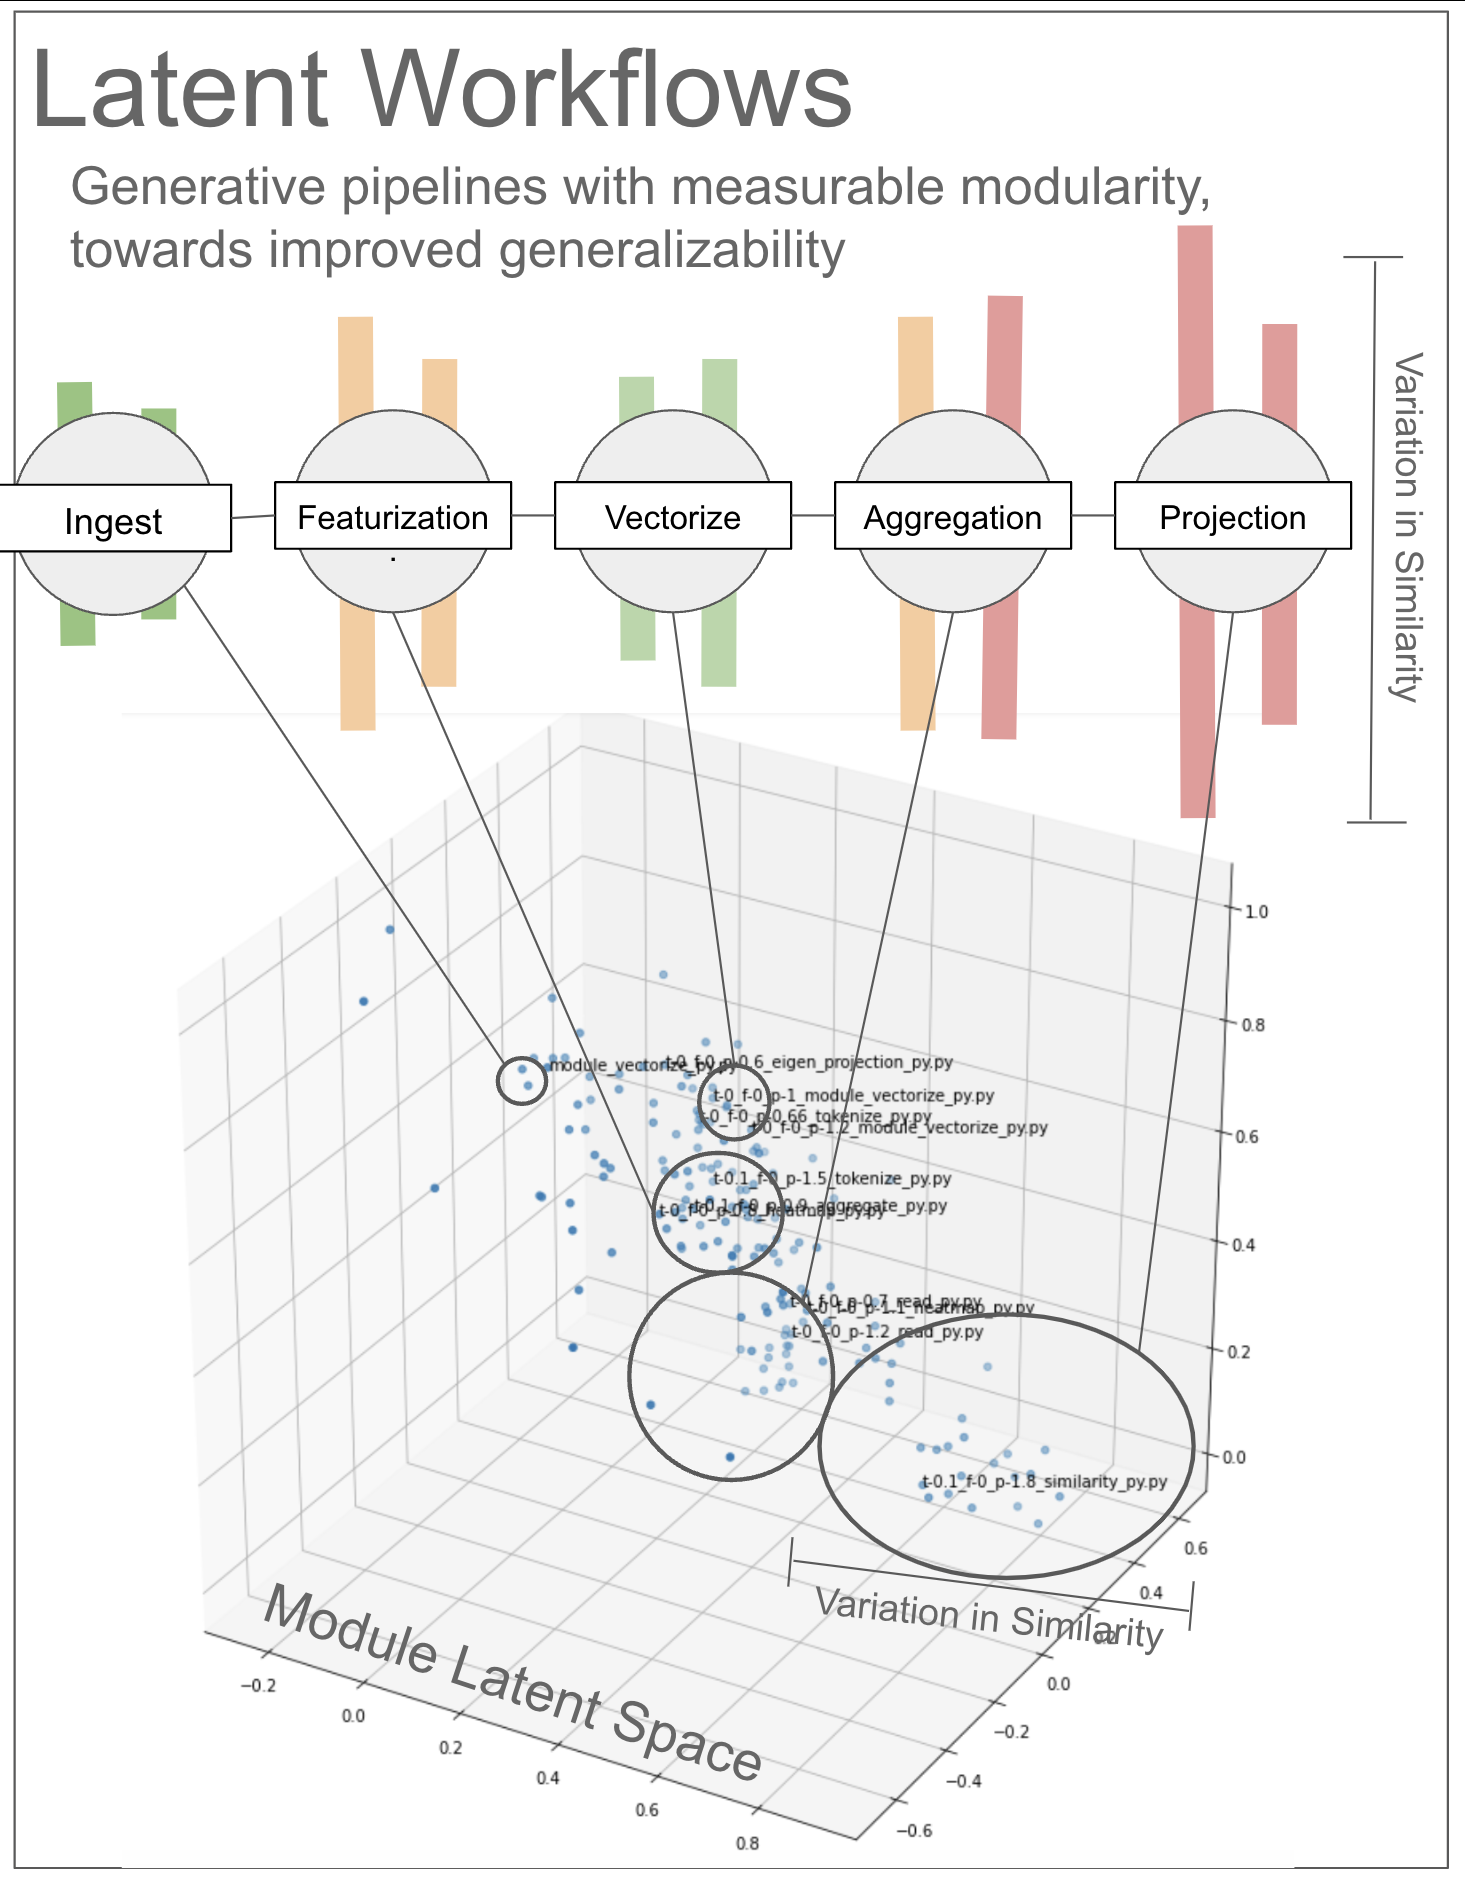

## Installs

In [139]:
# install openai
! pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [140]:
# engineering
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import re
import os
import time
import statistics

# module management
from importlib import reload

# gpt3 
import openai

# supply openai api key via file (a file uploaded simply containing your OpenAI token)
os.chdir('/content')
openai.api_key = open('openai_key').read()

## Config

In [141]:
### gpt3 parameters 
### (0.7, 0.2, -0.5 parameters found to be best in comparable experiment, definitely test others)
response_length_param = 2000
temperature_param = 0                   # between 0 - 1
frequency_penalty_param = 0             # between 0 - 2
presence_penalty_param = 0.8            # between 0 - 2 

# PROJECT_ID = "dehls-deluxo-engine"

# # Set the project id
# ! gcloud config set project {PROJECT_ID}
# REGION = "us-central1"

# # colab authentication
# from google.colab import auth
# auth.authenticate_user()

## Sub Functions

In [142]:
### OPENAI - Ask Davinci - build openai completion request, define parameters
def get_openai_response(question, response_length, engine):

    # format open au request
    response = openai.Completion.create(
                      engine=engine,
                      prompt=question,
                      temperature=temperature_param,
                      max_tokens=response_length,
                      top_p=1,
                      frequency_penalty=frequency_penalty_param,
                      presence_penalty=presence_penalty_param )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip()

    return response

In [143]:
## list to capture each request
all_requests = []

## Generate Ingestion Function
Functionality Checkpoint - 1/7

In [144]:
# prompt that describes a functions expected results
prompt = '''in python
          , return a function that takes the name of a csv file
          , ingests that csv from working directory 
            and returns a pandas dataframe
          , include libray imports such as "import pandas as pd"
          , do not include an example of usage of the function
          , the name of the csv ingestion function should be "get_dataframe"'''

# prompt gpt3
response = get_openai_response(prompt
                   , 256
                   ,'text-davinci-003')

# build script from result
f = open("read_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [145]:
# import generated script for usage
try:
  reload(read_py)
  
except:
  import read_py

# execute generated function supplying specific arguments
df = read_py.get_dataframe('games.csv')

## Feature Analysis
Functionality Checkpoint - 2/7  \
Quality Checkpoint - 1/5

In [146]:
# prompt that describes a functions expected results
prompt = '''in python
          , return a function that receives a pandas dataframe
          , it returns a new dataframe 
          , the new dataframe's first column has a row for each column of the supplied dataframe
          , the second column of the new dataframe is to be named "distinct_values"
            is an aggregated count of distinct values for each column of the supplied dataframe
          , the third column categorizes a columns content 
            as either continuous numeric, integer numeric, time since epoch date, categorical, boolean 
            or if a large string of space delimited tokens within each row then label sequential
          , the third columns name is 'data_type'
          , the forth column is a single random sample of the columns contents
          , do not include an example of the functions use
          , do include library imports
          , isolate the logic of the three generated columns with try and except clauses 
            as to ensure that no failue in the four operations causes an error in the complete process
          , if an error occurs during the generation of one of four columns, return the value "PROCESS_ERROR"
          , name the function "generate_column_counts"'''

# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("analyze_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [147]:
# import generated script for usage
try:
  reload(analyze_py)
  
except:
  import analyze_py

# execute generated function supplying specific arguments
df_analysis = analyze_py.generate_column_counts(df)
df_analysis

,column_name,distinct_values,data_type,example
0,id,19113,categorical,Co1hUpwB
1,rated,2,boolean,True
2,created_at,13151,continuous numeric,1501950000000.0
3,last_move_at,13186,continuous numeric,1486550000000.0
4,turns,211,integer numeric,65
5,victory_status,4,categorical,draw
6,winner,3,categorical,white
7,increment_code,400,categorical,8+5
8,white_id,9438,categorical,riddem_n_rims
9,white_rating,1516,integer numeric,1649


## Vectorize Moves
Functionality Checkpoint - 3/7

In [148]:
# prompt that describes a functions expected results
prompt = '''in python 
            write a function that takes a list of strings 
            and performs count vectorizer to expand the list into a dataframe 
            in which each column represents a token 
              and its occurence frequency for each token in each string in the provided list
            , name the function "tokenize_moves"
            , ensure all library imports are included
            return a dataframe with the results'''


# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("tokenize_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [149]:
# import generated script for usage
try:
  reload(tokenize_py)
  
except:
  import tokenize_py

# execute generated function supplying specific arguments
df_tokenize = tokenize_py.tokenize_moves(df['moves'])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Aggregation
Functionality Checkpoint - 4/7 \
Quality Checkpoint - 2/5

In [150]:
# prompt that describes a functions expected results
prompt = '''in python, 
            return a function that recieves two pandas dataframes and a string column name
            the first positional dataframe adds a column from the second postional dataframe, 
            the specific column being copied to the dataframe is the supplied string to the function, 
            finally group by the first dataframes newly added column, 
            performing mean aggregation to all other columns, 
            reset the dataframes index such that the grouped by column is not the index but a column
            name the function "label_vectorizor", 
            include all needed imports
            return the aggregated dataframe'''


# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("aggregate_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [151]:
# import generated script for usage
try:
  reload(aggregate_py)
  
except:
  import aggregate_py

# execute generated function supplying specific arguments
df_aggregate = aggregate_py.label_vectorizor(df_tokenize, df, "opening_name")
df_aggregate

,opening_name,a1,a2,a3,a4,a5,a6,a7,a8,axb1,...,rxg7,rxg8,rxh1,rxh2,rxh3,rxh4,rxh5,rxh6,rxh7,rxh8
0,Alekhine Defense,0.021739,0.021739,0.173913,0.173913,0.304348,0.217391,0.021739,0.00000,0.0,...,0.021739,0.0,0.0,0.0,0.065217,0.021739,0.021739,0.000000,0.021739,0.00000
1,Alekhine Defense #2,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,Alekhine Defense #3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,Alekhine Defense: Balogh Variation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,Alekhine Defense: Brooklyn Variation,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,Zukertort Opening: Slav Invitation,0.000000,0.000000,0.363636,0.272727,0.272727,0.181818,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.090909,0.000000,0.00000
1473,Zukertort Opening: Tennison Gambit,0.000000,0.000000,0.309524,0.285714,0.309524,0.261905,0.047619,0.02381,0.0,...,0.095238,0.0,0.0,0.0,0.023810,0.023810,0.023810,0.071429,0.071429,0.02381
1474,Zukertort Opening: The Walrus,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1475,Zukertort Opening: Vos Gambit,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


## 2 Dimensional Projection
Functionality Checkpoint - 5/7 \
Quality Checkpoint - 3/5

In [152]:
# prompt that describes a functions expected results
prompt = '''in python, 
            write a function that recieves a dataframe, 
            isolate string columns from numeric columns after sampling,
            numeric columns are to be collectively embedded into 2 dimensions,
            string columns are not embedded and copied exactly to return dataframe,
            return a dataframe with string classes and their 2 dimensional embeddings,
            name the function "eigen_projection",
            remove all text before and after function,
            include all import statements
            '''


# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("eigen_projection_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [153]:
# import generated script for usage
try:
  reload(eigen_projection_py)
  
except:
  import eigen_projection_py

# execute generated function supplying specific arguments  
arr_projection = eigen_projection_py.eigen_projection(df_aggregate)
arr_projection

,opening_name,dim1,dim2
0,Alekhine Defense,-0.313096,0.219280
1,Alekhine Defense #2,-0.151897,0.121303
2,Alekhine Defense #3,-1.263898,0.955267
3,Alekhine Defense: Balogh Variation,-1.234952,0.662637
4,Alekhine Defense: Brooklyn Variation,-0.720924,0.677797
...,...,...,...
1472,Zukertort Opening: Slav Invitation,-0.812787,0.583081
1473,Zukertort Opening: Tennison Gambit,-0.353408,0.265176
1474,Zukertort Opening: The Walrus,0.670248,-0.733534
1475,Zukertort Opening: Vos Gambit,-0.333330,0.039532


## Visualize Vector Space - 
Functionality Check - 6/7 \
Quality Check - 4/5

In [154]:
# prompt that describes a functions expected results
prompt = '''in python, 
            write a function that receives a dataframe, 
            sample 10 percent of the dataframe and determine string column for scatter plot point labels later
            use the sample to determine the best numeric columns to be used as x and y axis for a plot,
            make a scatter plot with figure size 15x15, only label 10 points,
            wrap point label mechanism in try and except statements to prevent errors during labeling,
            include all import statements,
            do not include an example of the functions use or any text before or after the function,
            call the function "heatmap_func"
            '''


# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("heatmap_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

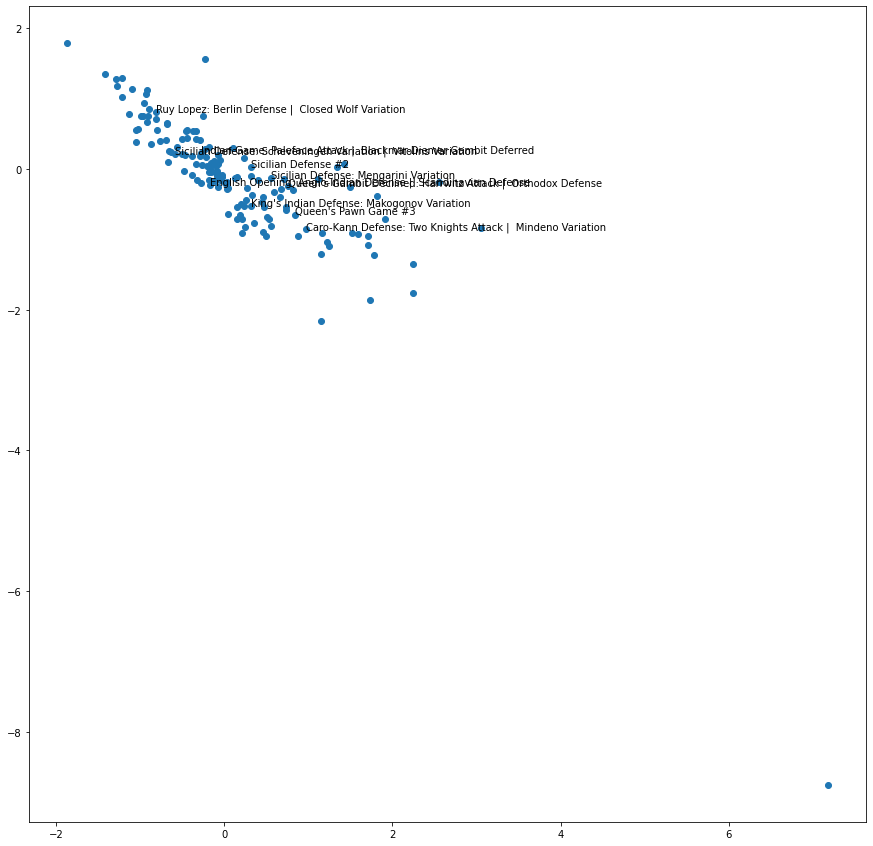

In [155]:
# import generated script for usage
try:
  reload(heatmap_py)
  
except:
  import heatmap_py

# execute generated function supplying specific arguments  
fn_heatmap = heatmap_py.heatmap_func(arr_projection)

## Opening Similarity
Functionality Check - 7/7 \
Quality Check - 5/5

In [173]:
# prompt that describes a functions expected results
prompt = '''in python, 
            write a function that receives a dataframe and string, 
            sample 10 percent of the dataframe and determine one string column to be used as index,
            the index column very likely contains the word 'opening', use this to find the column to act as index
            perform pairwise similiarity on all rows using numeric columns,
            use the supplied string to create a list of nodes containing the supplied string,
            return the 10 labels whose numeric values are closest to the list of filtered nodes,
            if any exception occurs, then return a list of 10 randomly selected string values,
            include import statements,
            call the function "similarity_func"
            '''

# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("similarity_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [174]:
# import generated script for usage
try:
  reload(similarity_py)
  
except:
  import similarity_py

# execute generated function supplying specific arguments  
similarity_py.similarity_func(arr_projection, "London")

/content/similarity_py.py:29: RuntimeWarning: Mean of empty slice.
  sim_scores = np.array(sim_scores).mean(axis=0)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['Caro-Kann Defense: Maroczy Variation']

## Record Modules
Functionality Check - 8/9 \
Quality Check - 6/7

In [158]:
# prompt that describes a functions expected results
prompt = '''in python, 
            write function that copies files fouind in the working diectory, 
            containing "_py.py" postfix, 
            into a directory within the working directory called "collection", 
            create the 'collection' directory if necessary.  
            The function recieves three arguments, "temp", "freq" and "pres", 
            turn these values to stings 
            and prefix the new, copied file names using these parameters in the format "t-{temp}_f-{freq}_p-{pres}_{filename}".  
            Name the function 'module_recorder' 
            and include all import statements,
            return a print statement displaying the percent increase in file numbers 
            in the 'collection' directory after the copy task
            '''


# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("meta_record_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [159]:
# import generated script for usage
try:
  reload(meta_record_py)
  
except:
  import meta_record_py

# execute generated function supplying specific arguments  
meta_record_py.module_recorder(temperature_param, frequency_penalty_param, presence_penalty_param)

The number of files increased by 263.6363636363636%


## Vectorize Modules
Functionality Check - 8/8 \
Quality Check - 7/7

In [160]:
# prompt that describes a functions expected results
prompt = '''in python, 
            return a function that vectorizes or embeds any document in a directory in the working directory called "collection", 
            the 3D embedding should represent each file and their similarity that contains "_py.py" in ints filename,
            the function should visualize the embedding space containing all documents, 
            so as to allow the user to visually compare how similiar documents are to one another, 
            use doc2vec or similiar approach to embed each document as one point in the vector spce visualized.
            Make the plots figure size 15 by 15.
            Avoid the error "scatter() takes from 2 to 13 positional arguments" if zip vectors. 
            Avoid the error "list indices must be integers or slices, not list" when labeling points.
            Label twelve of the embedded points using the points filename, do not label all points, 
            name the function 'embed_modules' and include all import statements
            '''

# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("module_vectorize_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

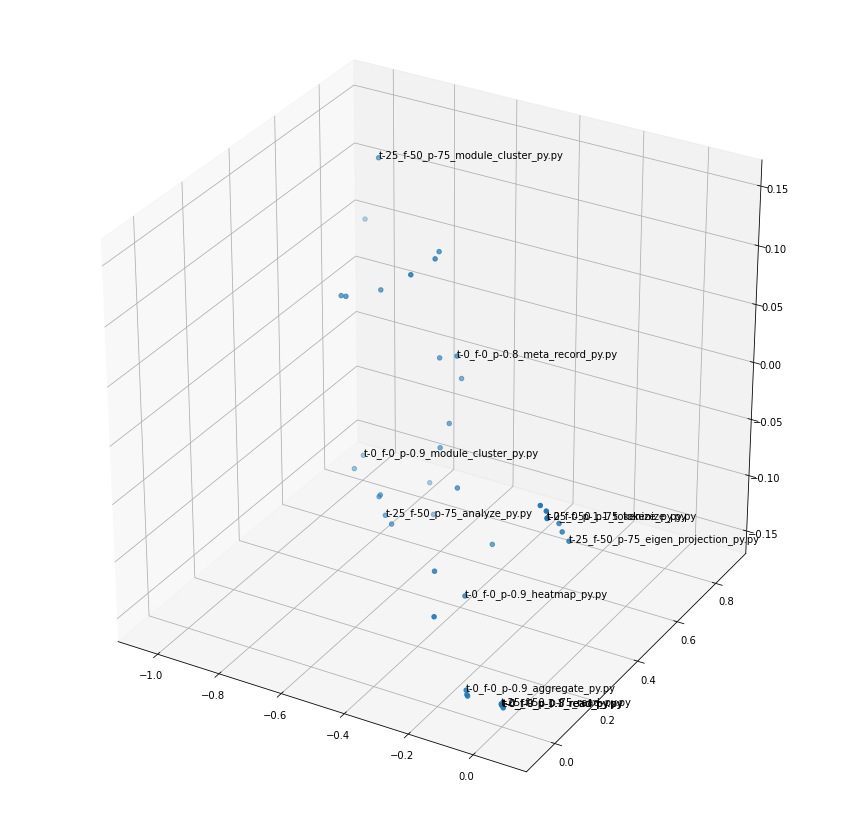

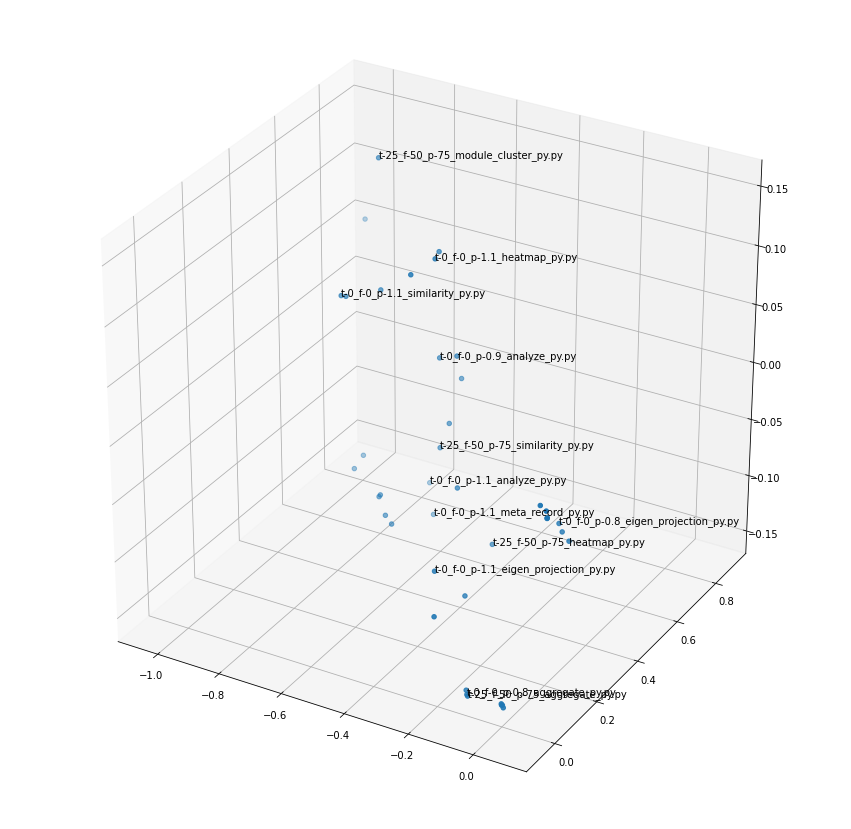

In [161]:
# import generated script for usage
try:
  reload(module_vectorize_py)
  
except:
  import module_vectorize_py

# execute generated function supplying specific arguments  
module_vectorize_py.embed_modules()

## Cluster Modules
Functionality Check - 9/9 \
Quality Check - 8/8

In [162]:
# prompt that describes a functions expected results
prompt = '''in python, 
            return a function that clusters similarity of documents in a directory in the working directory called "collection", 
            the unsupervised clustering should represent each file and their similarity that contains "_py.py" in its filename,
            the function should first find the optimal number of clusters, 
            less than 10 clusters though, 
            it should list each cluster and the files that most similarly makeup each cluster,
            return a dictionary of each cluster, the filenames of members, 
            also return a a scalar metric indicating similarity at each cluster members and variation within each cluster,
            name the function 'cluster_modules' and include all import statements.
            Avoid the error "cannot perform reduce with flexible type" when performing cosine similarity
            '''

# prompt gpt3
response = get_openai_response(prompt
                   , 1000
                   ,'text-davinci-003')

# build script from result
f = open("module_cluster_py.py", "w") 
print(response, file=f)
f.close()

# store response
all_requests.append(prompt)

In [163]:
# import generated script for usage
try:
  reload(module_cluster_py)
  
except:
  import module_cluster_py

# execute generated function supplying specific arguments  
results_json = module_cluster_py.cluster_modules()
results_json

({0: ['t-0_f-0_p-0.8_eigen_projection_py.py',
   't-0_f-0_p-0.9_eigen_projection_py.py',
   't-25_f-50_p-75_eigen_projection_py.py',
   't-0_f-0_p-1.1_eigen_projection_py.py'],
  1: ['t-0_f-0_p-0.9_module_cluster_py.py',
   't-0_f-0_p-0.8_prompt_cluster_py.py',
   't-25_f-50_p-75_module_vectorize_py.py',
   't-25_f-50_p-75_prompt_cluster_py.py',
   't-25_f-50_p-75_module_cluster_py.py',
   't-0_f-0_p-0.8_module_cluster_py.py',
   't-0_f-0_p-0.8_module_vectorize_py.py',
   't-0_f-0_p-0.9_module_vectorize_py.py'],
  2: ['t-0_f-0_p-0.9_aggregate_py.py',
   't-0_f-0_p-1.1_aggregate_py.py',
   't-25_f-50_p-75_aggregate_py.py',
   't-0_f-0_p-0.8_aggregate_py.py'],
  3: ['t-0_f-0_p-1.1_read_py.py',
   't-25_f-50_p-75_read_py.py',
   't-0_f-0_p-0.9_read_py.py',
   't-0_f-0_p-0.8_read_py.py'],
  4: ['t-25_f-50_p-75_analyze_py.py',
   't-0_f-0_p-0.8_analyze_py.py',
   't-0_f-0_p-1.1_analyze_py.py',
   't-0_f-0_p-0.9_analyze_py.py'],
  5: ['t-0_f-0_p-0.8_tokenize_py.py',
   't-0_f-0_p-1.1_tokeniz